In [56]:
#Importing libraries
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from torch.utils.data.dataset import Dataset, Subset

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold

from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch import Tensor

import warnings 
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

In [57]:
# Path of training and testing dataset
DIR_TRAIN = "C:\\Users\\yasht\\OneDrive\\Desktop\\Study\\AI\\Assignments\\AI Project Phase II\\TRAIN"
DIR_TEST_MALE = "C:\\Users\\yasht\\OneDrive\\Desktop\\Study\\AI\\Assignments\\AI Project Phase II\\TEST_CLASS\\male"
DIR_TEST_FEMALE = "C:\\Users\\yasht\\OneDrive\\Desktop\\Study\\AI\\Assignments\\AI Project Phase II\\TEST_CLASS\\female"
DIR_TEST_CHILDREN = "C:\\Users\\yasht\\OneDrive\\Desktop\\Study\\AI\\Assignments\\AI Project Phase II\\TEST_CLASS\\children"
DIR_TEST_YOUNG = "C:\\Users\\yasht\\OneDrive\\Desktop\\Study\\AI\\Assignments\\AI Project Phase II\\TEST_CLASS\\young"
DIR_TEST_OLD = "C:\\Users\\yasht\\OneDrive\\Desktop\\Study\\AI\\Assignments\\AI Project Phase II\\TEST_CLASS\\old"

In [58]:
# Labels (classes) to differentiate the images in these categories
label_dict = {
    0: "Cloth Mask", 
    1: "FFP2 Mask", 
    2: "Surgical Mask",
    3: "No Mask",
    4: "Incorrect Mask"
}

# Labels to display on the confussion matrix
labels_list = ["Cloth Mask","FFP2 Mask","Surgical Mask","No Mask","Incorrect Mask"]

In [59]:
#Displaying total images in each class and total number of images overall
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes),"\n")
#Counting total images in each class

total = 0
individual_count = []
for _class in classes:
    individual_count.append(len(os.listdir(DIR_TRAIN +"/"+_class)))
    total += len(os.listdir(DIR_TRAIN + "/"+_class))

for i in range(0,len(individual_count)):
  print(classes[i],": ", individual_count[i])
print("\n")
print("Total : ", total, "\n")

Total Classes:  5 

Cloth :  1172
FFP2 :  656
Incorrect mask :  1270
No Mask :  1042
Surgical :  1127


Total :  5267 



In [60]:
train_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN +"/"+ _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
        

class_to_int = {classes[i] : i for i in range(len(classes))}

In [61]:
#Loading Classification Dataset

transform = T.Compose([T.Resize((224,224)),
                                T.ToTensor()])

train_dataset = ImageFolder(root = DIR_TRAIN, transform = transform)

test_female_dataset = ImageFolder(root = DIR_TEST_FEMALE, transform = transform)
test_male_dataset = ImageFolder(root = DIR_TEST_MALE, transform = transform)
test_children_dataset = ImageFolder(root = DIR_TEST_CHILDREN, transform = transform)
test_young_dataset = ImageFolder(root = DIR_TEST_YOUNG, transform = transform)
test_old_dataset = ImageFolder(root = DIR_TEST_OLD, transform = transform)


In [62]:
# Female dataloader
testing_female_loader = DataLoader(test_female_dataset, batch_size=128, num_workers=0, shuffle=True)

# Male dataloader
testing_male_loader = DataLoader(test_male_dataset, batch_size=128, num_workers=0, shuffle=True)

# Children dataloader
testing_children_loader = DataLoader(test_children_dataset, batch_size=128, num_workers=0, shuffle=True)

# Young dataloader
testing_young_loader = DataLoader(test_young_dataset, batch_size=128, num_workers=0, shuffle=True)

# Old dataloader
testing_old_loader = DataLoader(test_old_dataset, batch_size=128, num_workers=0, shuffle=True)

In [63]:
class MaskDetect(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv6 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv7 = nn.Conv2d(256, 512, 3, 1, 1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1*1*512, 120)
        # self.fc1 = nn.Linear(14*14*64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv6(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv7(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 1*1*512)
        # X = X.view(-1, 14*14*64)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [64]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [65]:
#Defining function of accuracy calculation
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1) 
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.) 
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy() 

    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [66]:
#Training the model
def train_model(model, optimizer, criterion, train_data_loader, epochs):
      testing_accuracy = []

      for epoch in range(epochs):
          model.train()    
          start = time.time()
          
          #Epoch Loss & Accuracy
          train_epoch_loss = []
          train_epoch_accuracy = []
          _iter = 1
          
          #Value of  Loss & Accuracy
          val_epoch_loss = []
          val_epoch_accuracy = []
          
          #Training
          for images, labels in train_data_loader:
              
              images = images.to(device)
              labels = labels.to(device)
              
              #Reset Grads
              optimizer.zero_grad()
        
              #Forward ->
              preds = model(images)
              
              #Calculate Accuracy
              acc = calc_accuracy(labels.cpu(), preds.cpu())
              
              #Calculate Loss & Backward, Update Weights (Step)
              loss = criterion(preds, labels)
              loss.backward()
              optimizer.step()
              
              #Append loss & accuracy
              loss_value = loss.item()
              train_epoch_loss.append(loss_value)
              train_epoch_accuracy.append(acc)
              
              if _iter % 100 == 0:
                  print("> Iteration {} < ".format(_iter))
                  print("Iter Loss = {}".format(round(loss_value, 4)))
                  print("Iter Accuracy = {} % \n".format(acc))
              
              _iter += 1
          train_epoch_loss = np.mean(train_epoch_loss)
          train_epoch_accuracy = np.mean(train_epoch_accuracy)
          train_loss.append(train_epoch_loss)
          train_accuracy.append(train_epoch_accuracy)
          

          end = time.time()
          
          #Print Epoch Statistics
          print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
          print("Train Loss = {}".format(round(train_epoch_loss, 4)))



In [67]:
#Testing the model
def test_model(model, test_data_loader):
        testing_accuracy = []
        predictions_list = []
        accurate_list = []

        with torch.no_grad():

          for images, labels in test_data_loader:      
                # model.eval()
                images = images.to(device)
                labels = labels.to(device)
                _, pred_values = torch.max(model(images), dim=1)
                predictions_list.extend(pred_values.detach().cpu().numpy())
                accurate_list.extend(labels.detach().cpu().numpy())
                #Forward ->
                preds = model(images)
                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())
                testing_accuracy.append(acc);
        # fold_testing_accuracy = np.mean(testing_accuracy)
        fold_testing_accuracy = sum(testing_accuracy)/len(testing_accuracy)
        print("Mean Final Accuracy: ", np.mean(testing_accuracy),"\n")
        print("Average Final Accuracy: ", sum(testing_accuracy)/len(testing_accuracy),"\n")
        print("Testing Classification Report")
        print(classification_report(accurate_list, predictions_list),"\n")
        print("Confusion Matrix:")
        # plt.figure()
        confusion_matrix_instance = confusion_matrix(accurate_list, predictions_list)
        plt.imshow(confusion_matrix_instance, interpolation='nearest', cmap=plt.cm.Pastel2)
        for (x_cordinate, y_cordinate), val in np.ndenumerate(confusion_matrix_instance):
            plt.text(x_cordinate, y_cordinate, val, ha='center', va='center')
        plt.title('Testing Confusion matrix')
        plt.ylabel('Actual labels')
        plt.xlabel('Predicted labels')
        randomized_val = np.arange(len(labels_list))
        plt.xticks(randomized_val, labels_list, rotation=60)
        plt.yticks(randomized_val, labels_list)
        plt.show()

        return fold_testing_accuracy

Running Fold Num:  1
** Epoch 0 ** - Epoch Time 66
Train Loss = 1.6961
** Epoch 1 ** - Epoch Time 64
Train Loss = 1.3296
** Epoch 2 ** - Epoch Time 61
Train Loss = 1.0925
** Epoch 3 ** - Epoch Time 61
Train Loss = 0.9701
** Epoch 4 ** - Epoch Time 62
Train Loss = 0.8013
** Epoch 5 ** - Epoch Time 61
Train Loss = 0.675
** Epoch 6 ** - Epoch Time 62
Train Loss = 0.6056
** Epoch 7 ** - Epoch Time 62
Train Loss = 0.5
** Epoch 8 ** - Epoch Time 61
Train Loss = 0.3981
** Epoch 9 ** - Epoch Time 61
Train Loss = 0.3542
** Epoch 10 ** - Epoch Time 62
Train Loss = 0.3281
** Epoch 11 ** - Epoch Time 62
Train Loss = 0.2712
Mean Final Accuracy:  80.8854 

Average Final Accuracy:  80.8854 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       112
           1       0.59      0.57      0.58        58
           2       0.82      0.80      0.81       115
           3       0.86      0.89      0.88       107
           4 

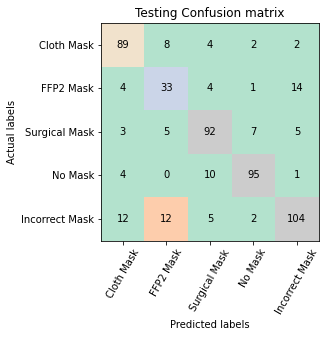

Running Fold Num:  2
** Epoch 0 ** - Epoch Time 63
Train Loss = 1.717
** Epoch 1 ** - Epoch Time 64
Train Loss = 1.5082
** Epoch 2 ** - Epoch Time 63
Train Loss = 1.2544
** Epoch 3 ** - Epoch Time 62
Train Loss = 1.0213
** Epoch 4 ** - Epoch Time 62
Train Loss = 0.8408
** Epoch 5 ** - Epoch Time 62
Train Loss = 0.7263
** Epoch 6 ** - Epoch Time 62
Train Loss = 0.5958
** Epoch 7 ** - Epoch Time 63
Train Loss = 0.5192
** Epoch 8 ** - Epoch Time 63
Train Loss = 0.4512
** Epoch 9 ** - Epoch Time 63
Train Loss = 0.3689
** Epoch 10 ** - Epoch Time 63
Train Loss = 0.3042
** Epoch 11 ** - Epoch Time 63
Train Loss = 0.2773
Mean Final Accuracy:  83.90628000000001 

Average Final Accuracy:  83.90628000000001 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       123
           1       0.53      0.68      0.60        57
           2       0.83      0.82      0.82       120
           3       0.88      0.94      0.91 

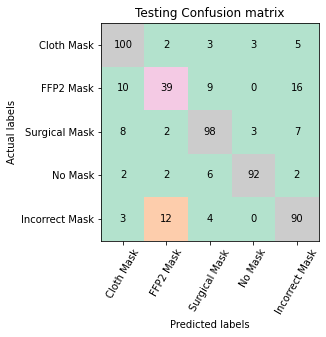

Running Fold Num:  3
** Epoch 0 ** - Epoch Time 62
Train Loss = 1.8087
** Epoch 1 ** - Epoch Time 62
Train Loss = 1.4466
** Epoch 2 ** - Epoch Time 62
Train Loss = 1.1671
** Epoch 3 ** - Epoch Time 64
Train Loss = 0.9931
** Epoch 4 ** - Epoch Time 62
Train Loss = 0.8698
** Epoch 5 ** - Epoch Time 62
Train Loss = 0.7265
** Epoch 6 ** - Epoch Time 62
Train Loss = 0.6055
** Epoch 7 ** - Epoch Time 62
Train Loss = 0.5327
** Epoch 8 ** - Epoch Time 62
Train Loss = 0.4597
** Epoch 9 ** - Epoch Time 62
Train Loss = 0.4081
** Epoch 10 ** - Epoch Time 62
Train Loss = 0.3527
** Epoch 11 ** - Epoch Time 62
Train Loss = 0.2975
Mean Final Accuracy:  82.60416000000001 

Average Final Accuracy:  82.60416000000001 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       110
           1       0.56      0.71      0.63        63
           2       0.88      0.83      0.85       140
           3       0.93      0.90      0.91

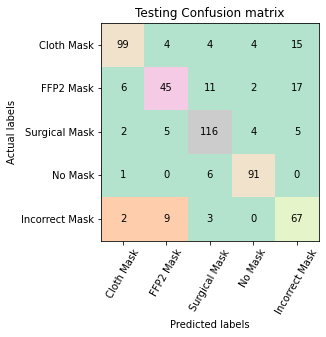

Running Fold Num:  4
** Epoch 0 ** - Epoch Time 61
Train Loss = 1.6018
** Epoch 1 ** - Epoch Time 62
Train Loss = 1.4372
** Epoch 2 ** - Epoch Time 63
Train Loss = 1.2776
** Epoch 3 ** - Epoch Time 63
Train Loss = 1.0256
** Epoch 4 ** - Epoch Time 63
Train Loss = 0.8721
** Epoch 5 ** - Epoch Time 63
Train Loss = 0.7233
** Epoch 6 ** - Epoch Time 65
Train Loss = 0.6227
** Epoch 7 ** - Epoch Time 62
Train Loss = 0.507
** Epoch 8 ** - Epoch Time 62
Train Loss = 0.4371
** Epoch 9 ** - Epoch Time 62
Train Loss = 0.3396
** Epoch 10 ** - Epoch Time 62
Train Loss = 0.3009
** Epoch 11 ** - Epoch Time 62
Train Loss = 0.2582
Mean Final Accuracy:  81.61458 

Average Final Accuracy:  81.61458 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       113
           1       0.71      0.80      0.75        50
           2       0.80      0.94      0.86       122
           3       0.90      0.92      0.91       111
        

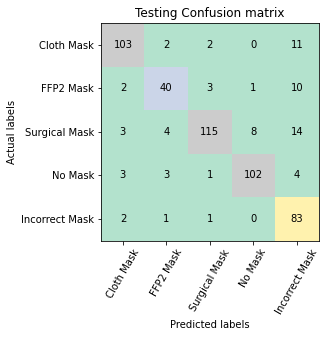

Running Fold Num:  5
** Epoch 0 ** - Epoch Time 62
Train Loss = 1.5821
** Epoch 1 ** - Epoch Time 63
Train Loss = 1.2945
** Epoch 2 ** - Epoch Time 62
Train Loss = 1.0224
** Epoch 3 ** - Epoch Time 63
Train Loss = 0.8426
** Epoch 4 ** - Epoch Time 63
Train Loss = 0.7033
** Epoch 5 ** - Epoch Time 63
Train Loss = 0.6493
** Epoch 6 ** - Epoch Time 63
Train Loss = 0.5157
** Epoch 7 ** - Epoch Time 63
Train Loss = 0.4753
** Epoch 8 ** - Epoch Time 64
Train Loss = 0.3747
** Epoch 9 ** - Epoch Time 63
Train Loss = 0.3197
** Epoch 10 ** - Epoch Time 62
Train Loss = 0.2822
** Epoch 11 ** - Epoch Time 62
Train Loss = 0.2108
Mean Final Accuracy:  85.10416000000001 

Average Final Accuracy:  85.10416000000001 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       120
           1       0.53      0.54      0.53        52
           2       0.93      0.87      0.90       127
           3       0.98      0.89      0.93

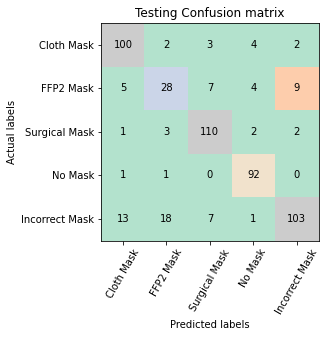

Running Fold Num:  6
** Epoch 0 ** - Epoch Time 63
Train Loss = 1.5918
** Epoch 1 ** - Epoch Time 62
Train Loss = 1.2614
** Epoch 2 ** - Epoch Time 63
Train Loss = 1.0741
** Epoch 3 ** - Epoch Time 64
Train Loss = 0.9103
** Epoch 4 ** - Epoch Time 64
Train Loss = 0.7857
** Epoch 5 ** - Epoch Time 64
Train Loss = 0.6471
** Epoch 6 ** - Epoch Time 64
Train Loss = 0.5726
** Epoch 7 ** - Epoch Time 64
Train Loss = 0.4884
** Epoch 8 ** - Epoch Time 65
Train Loss = 0.3953
** Epoch 9 ** - Epoch Time 65
Train Loss = 0.3329
** Epoch 10 ** - Epoch Time 67
Train Loss = 0.2673
** Epoch 11 ** - Epoch Time 65
Train Loss = 0.2237
Mean Final Accuracy:  83.38542 

Average Final Accuracy:  83.38542 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       118
           1       0.52      0.76      0.62        50
           2       0.93      0.81      0.86       129
           3       0.91      0.94      0.93       107
       

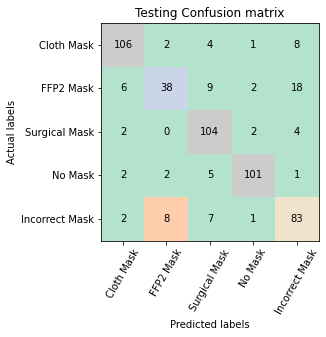

Running Fold Num:  7
** Epoch 0 ** - Epoch Time 65
Train Loss = 1.6513
** Epoch 1 ** - Epoch Time 64
Train Loss = 1.2879
** Epoch 2 ** - Epoch Time 64
Train Loss = 1.0941
** Epoch 3 ** - Epoch Time 64
Train Loss = 0.928
** Epoch 4 ** - Epoch Time 64
Train Loss = 0.7845
** Epoch 5 ** - Epoch Time 64
Train Loss = 0.6782
** Epoch 6 ** - Epoch Time 64
Train Loss = 0.5901
** Epoch 7 ** - Epoch Time 64
Train Loss = 0.4872
** Epoch 8 ** - Epoch Time 64
Train Loss = 0.4674
** Epoch 9 ** - Epoch Time 64
Train Loss = 0.4016
** Epoch 10 ** - Epoch Time 63
Train Loss = 0.3321
** Epoch 11 ** - Epoch Time 64
Train Loss = 0.2807
Mean Final Accuracy:  87.03121999999999 

Average Final Accuracy:  87.03121999999999 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       131
           1       0.94      0.47      0.63        70
           2       0.90      0.93      0.92       121
           3       0.88      0.92      0.90 

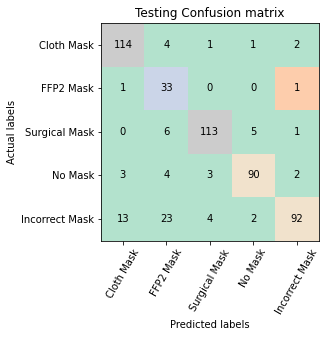

Running Fold Num:  8
** Epoch 0 ** - Epoch Time 65
Train Loss = 1.6656
** Epoch 1 ** - Epoch Time 64
Train Loss = 1.4291
** Epoch 2 ** - Epoch Time 66
Train Loss = 1.0929
** Epoch 3 ** - Epoch Time 65
Train Loss = 0.9006
** Epoch 4 ** - Epoch Time 64
Train Loss = 0.7405
** Epoch 5 ** - Epoch Time 64
Train Loss = 0.6518
** Epoch 6 ** - Epoch Time 64
Train Loss = 0.5103
** Epoch 7 ** - Epoch Time 64
Train Loss = 0.4269
** Epoch 8 ** - Epoch Time 64
Train Loss = 0.3667
** Epoch 9 ** - Epoch Time 63
Train Loss = 0.2952
** Epoch 10 ** - Epoch Time 64
Train Loss = 0.2597
** Epoch 11 ** - Epoch Time 66
Train Loss = 0.2927
Mean Final Accuracy:  85.46876 

Average Final Accuracy:  85.46876 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       118
           1       0.57      0.62      0.59        66
           2       0.76      0.93      0.84       121
           3       0.91      0.92      0.92       103
       

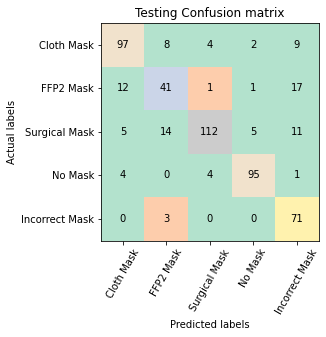

Running Fold Num:  9
** Epoch 0 ** - Epoch Time 65
Train Loss = 1.6452
** Epoch 1 ** - Epoch Time 63
Train Loss = 1.2968
** Epoch 2 ** - Epoch Time 66
Train Loss = 1.0928
** Epoch 3 ** - Epoch Time 64
Train Loss = 0.9045
** Epoch 4 ** - Epoch Time 64
Train Loss = 0.7962
** Epoch 5 ** - Epoch Time 64
Train Loss = 0.683
** Epoch 6 ** - Epoch Time 64
Train Loss = 0.5874
** Epoch 7 ** - Epoch Time 63
Train Loss = 0.5277
** Epoch 8 ** - Epoch Time 64
Train Loss = 0.4097
** Epoch 9 ** - Epoch Time 64
Train Loss = 0.384
** Epoch 10 ** - Epoch Time 63
Train Loss = 0.3363
** Epoch 11 ** - Epoch Time 66
Train Loss = 0.2642
Mean Final Accuracy:  86.71876 

Average Final Accuracy:  86.71876 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       119
           1       0.76      0.66      0.70        58
           2       0.84      0.91      0.88       124
           3       0.82      0.94      0.87       108
         

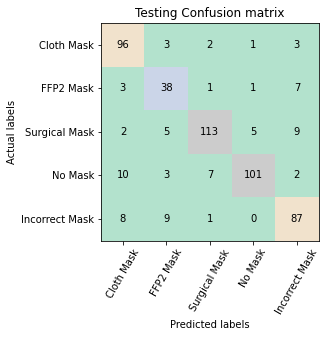

Running Fold Num:  10
** Epoch 0 ** - Epoch Time 67
Train Loss = 1.7248
** Epoch 1 ** - Epoch Time 64
Train Loss = 1.357
** Epoch 2 ** - Epoch Time 64
Train Loss = 1.1582
** Epoch 3 ** - Epoch Time 65
Train Loss = 1.0119
** Epoch 4 ** - Epoch Time 67
Train Loss = 0.816
** Epoch 5 ** - Epoch Time 65
Train Loss = 0.6945
** Epoch 6 ** - Epoch Time 65
Train Loss = 0.5938
** Epoch 7 ** - Epoch Time 65
Train Loss = 0.5092
** Epoch 8 ** - Epoch Time 64
Train Loss = 0.4043
** Epoch 9 ** - Epoch Time 65
Train Loss = 0.3555
** Epoch 10 ** - Epoch Time 65
Train Loss = 0.3088
** Epoch 11 ** - Epoch Time 64
Train Loss = 0.2589
Mean Final Accuracy:  83.65624 

Average Final Accuracy:  83.65624 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       108
           1       0.57      0.67      0.62        42
           2       0.84      0.91      0.87       151
           3       0.94      0.93      0.94       106
        

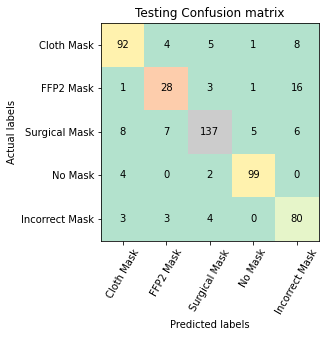

Average accuracy after running 10 folds is :  84.037498


In [68]:
#Get device
avg_testing_accuracy = []

epochs = 12
kfold = KFold(n_splits=10, shuffle=True, random_state=None)
fold_val = 1
max = 0
for training_idx, testing_idx in kfold.split(train_dataset):
        model = MaskDetect()
        model.apply(initialize_weights)
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        torch.cuda.empty_cache()

        model.to(device)


        #Training Details
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
        criterion = nn.CrossEntropyLoss()

        train_loss = []
        train_accuracy = []

        valid_loss = []
        valid_accuracy = []

        val_loss = []
        val_accuracy = []

        print("Running Fold Num: ", fold_val)
        training_dataset = Subset(train_dataset, training_idx)
        testing_dataset = Subset(train_dataset, testing_idx)
        training_loader = DataLoader(training_dataset, batch_size=128, num_workers=0,shuffle=True)
        testing_loader = DataLoader(testing_dataset, batch_size=128, num_workers=0, shuffle=True)
        return_model = train_model(model, optimizer, criterion, training_loader, epochs)
        testing_accuracy_of_each_fold = test_model(model, testing_loader)
        if testing_accuracy_of_each_fold > max:
            max = testing_accuracy_of_each_fold
            torch.save(model.state_dict(), "C:\\Users\\yasht\\OneDrive\\Desktop\\Study\\AI\\Assignments\\AI Project Phase II\\Trained_Model.pt")
        avg_testing_accuracy.append(testing_accuracy_of_each_fold)
        fold_val+=1


print("Average accuracy after running 10 folds is : ", sum(avg_testing_accuracy)/len(avg_testing_accuracy))

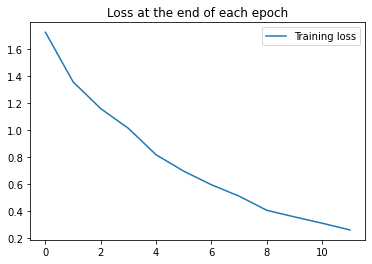

In [69]:
plt.plot(train_loss, label='Training loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()
# plt.plot(valid_loss, label='Validation loss')
# plt.title('Loss at the end of each epoch')
# plt.legend()

Testing for female data: 
Mean Final Accuracy:  18.0328 

Average Final Accuracy:  18.0328 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.65      0.48      0.55        27
           1       0.75      0.24      0.36        25
           2       0.11      0.12      0.11        26
           3       0.00      0.00      0.00        24
           4       0.09      0.15      0.11        20

    accuracy                           0.20       122
   macro avg       0.32      0.20      0.23       122
weighted avg       0.34      0.20      0.24       122
 

Confusion Matrix:


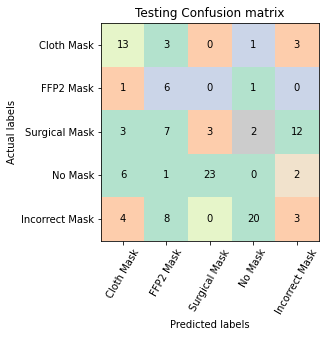

Testing for male data: 
Mean Final Accuracy:  22.1311 

Average Final Accuracy:  22.1311 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.82      0.52      0.64        27
           1       0.67      0.32      0.43        25
           2       0.21      0.20      0.20        25
           3       0.00      0.00      0.00        25
           4       0.10      0.20      0.14        20

    accuracy                           0.25       122
   macro avg       0.36      0.25      0.28       122
weighted avg       0.38      0.25      0.29       122
 

Confusion Matrix:


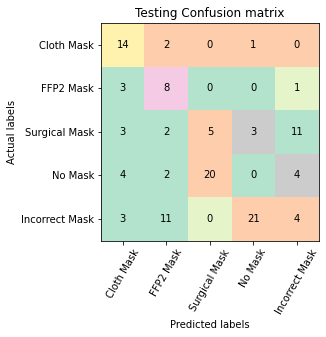

Testing for children data: 
Mean Final Accuracy:  22.7642 

Average Final Accuracy:  22.7642 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.76      0.52      0.62        25
           1       0.64      0.35      0.45        26
           2       0.03      0.04      0.03        26
           3       0.06      0.08      0.07        26
           4       0.00      0.00      0.00        20

    accuracy                           0.20       123
   macro avg       0.30      0.20      0.23       123
weighted avg       0.31      0.20      0.24       123
 

Confusion Matrix:


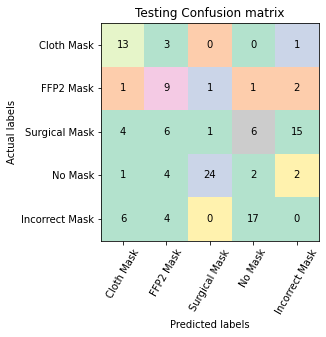

Testing for young data: 
Mean Final Accuracy:  21.3115 

Average Final Accuracy:  21.3115 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.77      0.80      0.78        25
           1       0.67      0.16      0.26        25
           2       0.04      0.04      0.04        26
           3       0.00      0.00      0.00        26
           4       0.03      0.05      0.04        20

    accuracy                           0.21       122
   macro avg       0.30      0.21      0.22       122
weighted avg       0.31      0.21      0.23       122
 

Confusion Matrix:


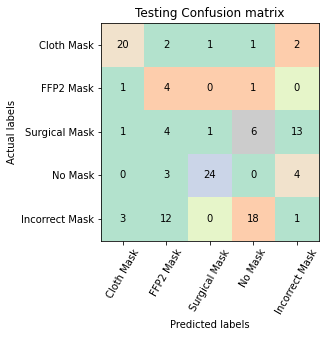

Testing for old data: 
Mean Final Accuracy:  27.2727 

Average Final Accuracy:  27.2727 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.76      0.52      0.62        25
           1       0.50      0.22      0.30        23
           2       0.22      0.35      0.27        26
           3       0.04      0.04      0.04        27
           4       0.10      0.15      0.12        20

    accuracy                           0.26       121
   macro avg       0.33      0.25      0.27       121
weighted avg       0.33      0.26      0.27       121
 

Confusion Matrix:


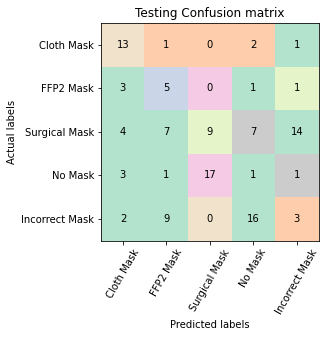

27.2727

In [70]:
model = MaskDetect()
model = model.to(device)
model.load_state_dict(torch.load('C:\\Users\\yasht\\OneDrive\\Desktop\\Study\\AI\\Assignments\\AI Project Phase II\\Trained_Model.pt', map_location=device))

print("Testing for female data: ")
test_model(model, testing_female_loader)

#Testing for male data
print("Testing for male data: ")
test_model(model, testing_male_loader)

#Testing for children data
print("Testing for children data: ")
test_model(model, testing_children_loader)

#Testing for young data
print("Testing for young data: ")
test_model(model, testing_young_loader)

#Testing for old data
print("Testing for old data: ")
test_model(model, testing_old_loader)